In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from datetime import timedelta


In [2]:
df = pd.read_excel("test.xlsx")

df['date'] = pd.to_datetime(df['date'])
df.head()


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


In [3]:
!pip install textblob


In [4]:
from textblob import TextBlob

def label_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['body'].apply(label_sentiment)
df.head()


,Subject,body,date,from,Sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Neutral
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Neutral


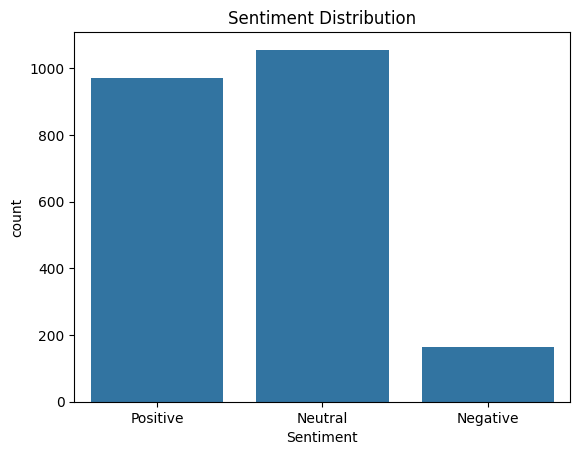

In [5]:
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Distribution")
plt.show()


/tmp/ipython-input-1990805790.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('date').resample('M').size().plot()


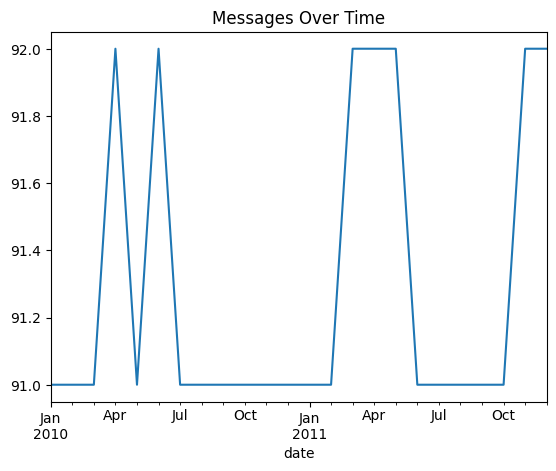

In [6]:
df.set_index('date').resample('M').size().plot()
plt.title("Messages Over Time")
plt.show()


In [7]:
sentiment_score = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['Score'] = df['Sentiment'].map(sentiment_score)

df['Month'] = df['date'].dt.to_period('M')


In [8]:
monthly_scores = (
    df.groupby(['from', 'Month'])['Score']
    .sum()
    .reset_index()
    .rename(columns={'from': 'Employee', 'Score': 'Monthly_Score'})
)

monthly_scores.head()


,Employee,Month,Monthly_Score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,1


In [9]:
def top_employees(monthly_df):
    top_pos = monthly_df.sort_values(
        ['Monthly_Score', 'Employee'], ascending=[False, True]
    ).groupby('Month').head(3)

    top_neg = monthly_df.sort_values(
        ['Monthly_Score', 'Employee'], ascending=[True, True]
    ).groupby('Month').head(3)

    return top_pos, top_neg

top_positive, top_negative = top_employees(monthly_scores)


In [10]:
neg_df = df[df['Sentiment'] == 'Negative'][['from', 'date']]
neg_df = neg_df.sort_values(['from', 'date'])

flight_risk = []

for emp, group in neg_df.groupby('from'):
    dates = group['date'].tolist()
    for i in range(len(dates)):
        window = [d for d in dates if dates[i] <= d <= dates[i] + timedelta(days=30)]
        if len(window) >= 4:
            flight_risk.append(emp)
            break

flight_risk_employees = list(set(flight_risk))
flight_risk_employees


['sally.beck@enron.com',
 'johnny.palmer@enron.com',
 'john.arnold@enron.com',
 'rhonda.denton@enron.com',
 'lydia.delgado@enron.com',
 'patti.thompson@enron.com',
 'bobette.riner@ipgdirect.com']

In [11]:
df['msg_length'] = df['body'].apply(lambda x: len(str(x)))
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

features = (
    df.groupby(['from', 'Month'])
    .agg(
        message_count=('body', 'count'),
        avg_msg_length=('msg_length', 'mean'),
        avg_word_count=('word_count', 'mean'),
        sentiment_score=('Score', 'sum')
    )
    .reset_index()
)


In [14]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)


R2 Score: 0.43212696939685247
RMSE: 1.995189235541652


In [15]:
print("R2 Score:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


R2 Score: 0.43212696939685247
RMSE: 1.995189235541652
